# Trump Tweets network analysis

by [Brian Keegan, Ph.D.](https://www.brianckeegan.com), Assistant Professor, University of Colorado Boulder

In [9]:
import numpy as np
import pandas as pd

import re
import networkx as nx

from

import matplotlib.pyplot as plt
%matplotlib inline

The data is taken from bpb27's [Trump Tweet Archive](https://github.com/bpb27/trump-tweet-archive/tree/master/data/realdonaldtrump) running from 2009 through the end of 2017.

In [41]:
trump_tweets_df = pd.read_csv('trump_tweets.csv',sep='\t',parse_dates=['created_at','timestamp','date'])
trump_tweets_df['year'] = trump_tweets_df['date'].apply(lambda x:x.year)
print("There are {0:,} rows of data in trump_tweets_df.".format(len(trump_tweets_df)))
trump_tweets_df.head()

There are 32,797 rows of data in trump_tweets_df.


,created_at,favorite_count,id_str,in_reply_to_user_id_str,is_retweet,retweet_count,source,text,timestamp,date,year
0,2009-12-23 17:38:18,12,6971079756,NaN,False,28,Twitter Web Client,From Donald Trump: Wishing everyone a wonderfu...,2009-12-23 17:38:18,2009-12-23,2009
1,2009-12-03 19:39:09,6,6312794445,NaN,False,33,Twitter Web Client,Trump International Tower in Chicago ranked 6t...,2009-12-03 19:39:09,2009-12-03,2009
2,2009-11-26 19:55:38,11,6090839867,NaN,False,13,Twitter Web Client,Wishing you and yours a very Happy and Bountif...,2009-11-26 19:55:38,2009-11-26,2009
3,2009-11-16 21:06:10,3,5775731054,NaN,False,5,Twitter Web Client,Donald Trump Partners with TV1 on New Reality ...,2009-11-16 21:06:10,2009-11-16,2009
4,2009-11-02 14:57:56,6,5364614040,NaN,False,7,Twitter Web Client,"--Work has begun, ahead of schedule, to build ...",2009-11-02 14:57:56,2009-11-02,2009


Write a regex to match handles in the "text" column.

In [48]:
# Regex from: https://stackoverflow.com/a/46633886/1574687
trump_tweets_df['mentions'] = trump_tweets_df['text'].str.findall(r'(?<![@\w])@(\w{1,25})')

# Boolean index to only match tweets with more than one mention in it
multiple_mentions = trump_tweets_df.loc[trump_tweets_df['mentions'].apply(len) > 1]
multiple_mentions.head()

,created_at,favorite_count,id_str,in_reply_to_user_id_str,is_retweet,retweet_count,source,text,timestamp,date,year,mentions
152,2010-05-21 13:54:57,4,14429237277,NaN,False,7,Twitter Web Client,Who's your pick--@bretmichaels or @hollyrpeete...,2010-05-21 13:54:57,2010-05-21,2010,"[bretmichaels, hollyrpeete]"
214,2011-12-28 14:51:24,0,152038948594651136,67119128.0,False,3,TwitLonger Beta,@TrumpCollection tops @TravlandLeisure 500 Bes...,2011-12-28 14:51:24,2011-12-28,2011,"[TrumpCollection, TravlandLeisure, TrumpNewYor..."
230,2011-12-22 19:17:15,5,149931522626043904,NaN,False,21,Twitter Web Client,My @FoxNews interview with @gretawire discussi...,2011-12-22 19:17:15,2011-12-22,2011,"[FoxNews, gretawire, BarackObama]"
250,2011-12-20 15:58:09,8,149156644171948032,NaN,False,19,Twitter Web Client,We're all proud of @erictrump for being on @Fo...,2011-12-20 15:58:09,2011-12-20,2011,"[erictrump, Forbes]"
259,2011-12-19 15:05:52,14,148781095998070784,NaN,False,23,Twitter Web Client,My interview with Andy Dean on @americanowradi...,2011-12-19 15:05:52,2011-12-19,2011,"[americanowradio, FoxNews]"


Turn the "mentions" column into a list.

In [47]:
multiple_mentions_l = list(multiple_mentions['mentions'].values)
multiple_mentions_l[:3]

[['bretmichaels', 'hollyrpeete'],
 ['TrumpCollection',
  'TravlandLeisure',
  'TrumpNewYork',
  'TrumpLasVegas',
  'TrumpChicago',
  'TrumpSoHo'],
 ['FoxNews', 'gretawire', 'BarackObama']]

Make a graph.

In [61]:
trump_mentions_g = nx.Graph()

for year in range(2009,2018):
    sub_df = multiple_mentions.loc[multiple_mentions['year'] == year]
    multiple_mentions_subdf_l = list(sub_df['mentions'].values)

    # Loop through the list of lists
    for mention_list in multiple_mentions_subdf_l:

        # For each name mentioned
        for mention1 in mention_list:
            for mention2 in mention_list:

                # Lowercase the names to ensure consistency
                m1 = mention1.lower()
                m2 = mention2.lower()

                # Check to make sure there are no self-loops or mentions of "realdonaldtrump"
                if m1 != m2 and m1 != "realdonaldtrump" and m2 != "realdonaldtrump":

                    # If the network already has an edge
                    if trump_mentions_g.has_edge(m1,m2):

                        # Increment the edge weight by 0.5 (we visit each edge twice)
                        try:
                            trump_mentions_g[m1][m2]['weight'] += .5
                            trump_mentions_g[m1][m2]['max_year'] = year
                        except KeyError:
                            trump_mentions_g[m2][m1]['weight'] += .5
                            trump_mentions_g[m2][m1]['max_year'] = year

                    # If the network doesn't already have the edge, add it with edge weight 0.5 (we visit each edge twice)
                    else:
                        trump_mentions_g.add_edge(m1,m2,weight = .5, min_year = year, max_year = year)
                        
    print("There are {0:,} nodes and {1:,} edges in year {2}.".format(trump_mentions_g.number_of_nodes(),
                                                                      trump_mentions_g.number_of_edges(),
                                                                      year))
    
nx.write_gexf(trump_mentions_g,'trump_mentions.gexf')

There are 0 nodes and 0 edges in year 2009.
There are 2 nodes and 1 edges in year 2010.
There are 86 nodes and 119 edges in year 2011.
There are 457 nodes and 639 edges in year 2012.
There are 1,959 nodes and 2,450 edges in year 2013.
There are 3,563 nodes and 4,479 edges in year 2014.
There are 6,070 nodes and 8,811 edges in year 2015.
There are 6,469 nodes and 9,559 edges in year 2016.
There are 6,599 nodes and 9,837 edges in year 2017.


## Filter to only edges where dyads were mentioned more than once

In [68]:
trump_mentions_edges_gt1 = [(m1,m2,d) for (m1,m2,d) in trump_mentions_g.edges(data=True) if d['weight'] > 1]

trump_mentions_gt1_g = nx.Graph()
trump_mentions_gt1_g.add_edges_from(trump_mentions_edges_gt1)
print("There are {0:,} nodes and {1:,} edges in trump_mentions_gt1_g.".format(trump_mentions_gt1_g.number_of_nodes(), 
                                                                              trump_mentions_gt1_g.number_of_edges()))

nx.write_gexf(trump_mentions_gt1_g,'trump_mentions_gt1.gexf')

There are 1,090 nodes and 1,449 edges in trump_mentions_gt1_g.


In [70]:
trump_mentions_gt1_g.edges(data=True)

EdgeDataView([('bretmichaels', 'celebapprentice', {'weight': 7.0, 'min_year': 2012, 'max_year': 2013}), ('bretmichaels', 'apprenticenbc', {'weight': 4.0, 'min_year': 2013, 'max_year': 2013}), ('bretmichaels', 'nbc', {'weight': 2.0, 'min_year': 2013, 'max_year': 2013}), ('celebapprentice', 'donaldjtrumpjr', {'weight': 3.0, 'min_year': 2012, 'max_year': 2013}), ('celebapprentice', 'foxandfriends', {'weight': 2.0, 'min_year': 2012, 'max_year': 2013}), ('celebapprentice', 'apprenticenbc', {'weight': 3.0, 'min_year': 2013, 'max_year': 2015}), ('celebapprentice', 'mittromney', {'weight': 2.0, 'min_year': 2012, 'max_year': 2012}), ('celebapprentice', 'ivankatrump', {'weight': 9.0, 'min_year': 2012, 'max_year': 2015}), ('celebapprentice', 'todayshow', {'weight': 2.0, 'min_year': 2012, 'max_year': 2013}), ('celebapprentice', 'liljon', {'weight': 4.0, 'min_year': 2012, 'max_year': 2013}), ('celebapprentice', 'pennjillette', {'weight': 2.0, 'min_year': 2012, 'max_year': 2012}), ('celebapprentice'

## Make a graph for each year

In [77]:
graph_d = {}

for year in range(2009,2018):
    sub_df = multiple_mentions.loc[multiple_mentions['year'] == year]
    multiple_mentions_subdf_l = list(sub_df['mentions'].values)

    # Initialize the empty undirected graph object
    year_g = nx.Graph()

    # Loop through the list of lists
    for mention_list in multiple_mentions_subdf_l:

        # For each name mentioned
        for mention1 in mention_list:
            for mention2 in mention_list:

                # Lowercase the names to ensure consistency
                m1 = mention1.lower()
                m2 = mention2.lower()

                # Check to make sure there are no self-loops or mentions of "realdonaldtrump"
                if m1 != m2 and m1 != "realdonaldtrump" and m2 != "realdonaldtrump":

                    # If the network already has an edge
                    if year_g.has_edge(m1,m2):

                        # Increment the edge weight by 0.5 (we visit each edge twice)
                        try:
                            year_g[m1][m2]['weight'] += .5
                        except KeyError:
                            year_g[m2][m1]['weight'] += .5

                    # If the network doesn't already have the edge, add it with edge weight 0.5 (we visit each edge twice)
                    else:
                        year_g.add_edge(m1,m2,weight = .5)
                        
    print("There are {0:,} nodes and {1:,} edges in year {2}.".format(year_g.number_of_nodes(),
                                                                      year_g.number_of_edges(),
                                                                      year))
    nx.write_gexf(year_g,'trump_mentions_{0}.gexf'.format(year))
    if len(year_g) > 0:
        graph_d[year] = year_g

There are 0 nodes and 0 edges in year 2009.
There are 2 nodes and 1 edges in year 2010.
There are 85 nodes and 118 edges in year 2011.
There are 415 nodes and 550 edges in year 2012.
There are 1,665 nodes and 1,873 edges in year 2013.
There are 1,825 nodes and 2,089 edges in year 2014.
There are 2,887 nodes and 4,460 edges in year 2015.
There are 587 nodes and 828 edges in year 2016.
There are 203 nodes and 304 edges in year 2017.


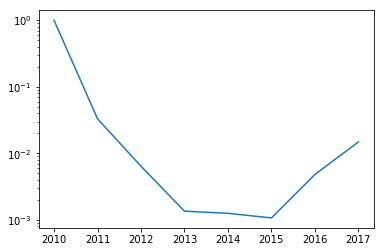

In [78]:
pd.Series({year:nx.density(g) for year,g in graph_d.items()}).plot(logy=True)

C:\ProgramData\Anaconda3\lib\site-packages\networkx\algorithms\assortativity\correlation.py:288: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / numpy.sqrt(vara * varb)


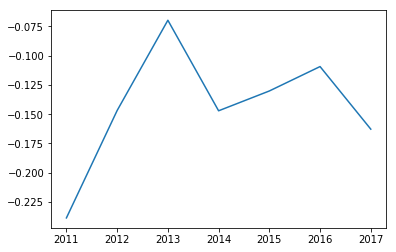

In [85]:
pd.Series({year:nx.degree_assortativity_coefficient(g) for year,g in graph_d.items()}).plot()

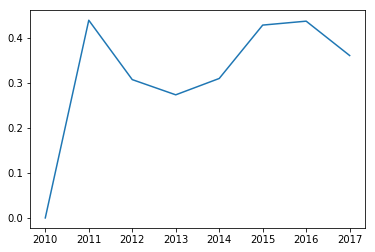

In [82]:
pd.Series({year:nx.average_clustering(g) for year,g in graph_d.items()}).plot()